<a href="https://colab.research.google.com/github/ymiftah/operations_research/blob/master/unit_commitment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Unit Commitment problem

Thermal power units operate under various temporal operational constraints such as:
* Ramping constraints
* Uptime constraints
* Minimum downtime
* Reserve constraints
* Security constraints

To serve the demand over time, the units must be carefully scheduled to respect all these constraints

# Prerequisites

Installing energysys library and some packages

In [2]:
!rm -r energysys
!git clone https://github.com/ymiftah/energysys.git
!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64
!apt-get install -y -qq coinor-cbc
!pip install -q pyomo

rm: cannot remove 'energysys': No such file or directory
Cloning into 'energysys'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 155 (delta 85), reused 116 (delta 50), pack-reused 0
Receiving objects: 100% (155/155), 6.13 MiB | 21.42 MiB/s, done.
Resolving deltas: 100% (85/85), done.
Selecting previously unselected package coinor-libcoinutils3v5.
(Reading database ... 155219 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.10.14+repack1-1_amd64.deb ...
Unpacking coinor-libcoinutils3v5 (2.10.14+repack1-1) ...
Selecting previously unselected package coinor-libosi1v5.
Preparing to unpack .../1-coinor-libosi1v5_0.107.9+repack1-1_amd64.deb ...
Unpacking coinor-libosi1v5 (0.107.9+repack1-1) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.16.11+repack1-1_amd64.deb ...
Unpacking coinor-lib

In [3]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from energysys.systems.thermal import ThermalUnit
from energysys.systems.core import UCSystem
from energysys.solvers.unit_commitment import LPModel
import plotly.express as px
import pandas as pd

plt.style.use('ggplot')

# Unit Commitment

How to dispatch thermal units with constraints (ramping constraints, up/downtime constraints, ...) in order to satisfy the demand.

Thermal units are defined by their input-output curve, fuel cost, min/max power and operational constraints.

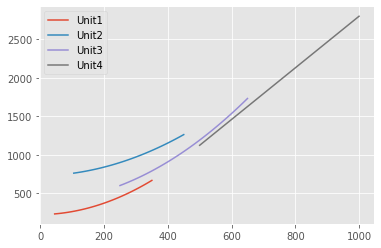

In [22]:
sys = UCSystem(
        (ThermalUnit("Unit1", [225,  0.044, .0035],   .8,
                     min_power=45, max_power=350, start_up_cost=1000,
                     ramp_up=200, ramp_down=200,
                     min_uptime=10, min_rest=5),
         ThermalUnit("Unit2", [729, .063, .0025], 1.02,
                     min_power=105, max_power=450, start_up_cost=1000,
                     ramp_up=200, ramp_down=200,
                     min_uptime=10, min_rest=5),
         ThermalUnit("Unit3", [400,  .035, .0031],   .9,
                     min_power=250, max_power=650, start_up_cost=1000,
                     ramp_up=200, ramp_down=200,
                     min_uptime=10, min_rest=5),
         ThermalUnit("Unit4", [-550,  3.35, .00],   .9,
                     min_power=500, max_power=1000, start_up_cost=1000,
                     ramp_up=100, ramp_down=100,
                     min_uptime=20, min_rest=5)
        )
    )

sys.plot_input_output()

We define the loads as a sum of a constant base load term, a periodic term and a random term

In [25]:
def make_load(T=12, D=3, C=250, P=50, R=10):
    L = T
    load = np.ones(L) * C + P * np.cos(2*np.pi/T*np.arange(L)) + R * np.random.randn(L)
    load += 20 * np.cos(1.5*np.pi/T*np.arange(L)-3)
    load = np.concatenate([load for _ in range(D)])
    return load

load = make_load(C=600, P=200, R=50)
d = pd.DataFrame({'load': load})

fig = px.area(d, y='load')
fig.show()

In [26]:
lpm = LPModel(sys)
res = lpm.solve(load, exec='/usr/bin/cbc')
print(res)
d = lpm.get_power()
fig = px.area(d, x='Time', y='Power', color='Unit')
fig.show()

(True, 40061.327889)


## DC Model

A DC Model takes into account the power flow in the lines of a grid. 

In [12]:
from energysys.systems.core import Line, Network

sys = UCSystem(
        (ThermalUnit("Unit1", [0, 1, .00],   5,
                    min_power=80, max_power=300,
                    start_up_cost=800, ramp_up=50, ramp_down=30,
                    min_uptime = 3, min_rest=2),
         ThermalUnit("Unit2", [0, 1, .00],   15,
                    min_power=50, max_power=200,
                    start_up_cost=500, ramp_up=60, ramp_down=40,
                    min_uptime = 2, min_rest=2),
         ThermalUnit("Unit3", [0, 1, .00],   30,
                    min_power=30, max_power=100,
                    start_up_cost=250, ramp_up=70, ramp_down=50,
                    min_uptime = 1, min_rest=2),
         )
    )

load = {4:np.array([100, 100, 80, 140, 100, 80]),
        5:np.array([80, 100, 80, 30, 90, 60]),
        6:np.array([50,50,40,0,40,50])}

lines = [Line((1,4), power_lim=450, Z=100),
         Line((1,5), power_lim=450, Z=100),
         Line((1,6), power_lim=450, Z=100),
         Line((2,4), power_lim=450, Z=100),
         Line((2,5), power_lim=450, Z=100),
         Line((2,6), power_lim=450, Z=100),
         Line((3,5), power_lim=450, Z=100),
         Line((3,6), power_lim=450, Z=100)
         ]
links = {(1, "Unit1"), (2, "Unit2"), (3, "Unit3")}
net = Network(lines, sys, links)

In [13]:
from energysys.solvers.unit_commitment import DCModel

dcm = DCModel(net)
res, val = dcm.solve(load, exec='/usr/bin/cbc')
print('Optimal ? : {}'.format(res))
print('Value : {}'.format(val))
d = dcm.get_power()
fig = px.area(d, x='Time', y='Power', color='Unit')
fig.show()

Optimal ? : True
Value : 8350.0


## Security Constrained DC

Grid Operators need to ensure that in the case of a line defecting, the available units can still pick up the load and provide the necessary power. Doing otherwise would open the doors to eventual blackouts.

The Security Constrained DC Unit Commitment finds a dispatch that allow the grid to sustain the loss of a line (n-1 Security).


In [14]:
from energysys.solvers.unit_commitment import SCDCModel

lines = [Line((1,4), power_lim=450, Z=100),
         Line((2,5), power_lim=450, Z=100),
         Line((3,6), power_lim=450, Z=100),
         Line((4,5), power_lim=450, Z=100),
         Line((5,6), power_lim=450, Z=100),
         ]
links = {(1, "Unit1"), (2, "Unit2"), (3, "Unit3")}
net = Network(lines, sys, links)


scdcm = SCDCModel(net)
scdcm.solve(load, contingencies=[(1,4)], exec='/usr/bin/cbc')
d = scdcm.get_power()
fig = px.area(d, x='Time', y='Power', color='Unit')
fig.show()